**Libraries used across the project:**
```
!pip install usgs
!pip install image_slicer
```



In [ ]:
!pip install usgs

In [ ]:
from usgs import api
from getpass import getpass

In [ ]:
api.logout()

{'data': None,
 'errorCode': None,
 'errorMessage': None,
 'requestId': 278238949,
 'sessionId': 58637142,
 'version': 'stable'}

In [ ]:
username=getpass("Enter username: ")
password=getpass("Enter password: ")

Enter username:··········
Enter password:··········


In [ ]:
login_response_data = api.login(username, password)
username=""
password=""

In [ ]:
"""
Configuring dataset parameters
"""
# Albuquerque - New Mexico, US
LOWER_LEFT_LAT = 35.0562
LOWER_LEFT_LONG = -106.6839
UPPER_RIGHT_LAT = 35.1731
UPPER_RIGHT_LONG = -106.4890

dataset="HIGH_RES_ORTHO"
lower_left_coord = {'latitude': LOWER_LEFT_LAT, 'longitude': LOWER_LEFT_LONG}
upper_right_coord = {'latitude': UPPER_RIGHT_LAT, 'longitude': UPPER_RIGHT_LONG}
start_date = 20130826 #2013-08-26

In [ ]:
"""
Fetch a pool of scenes within the defined rectangle
"""
scene_search_response = api.scene_search(dataset=dataset, max_results=1000, ll=lower_left_coord, ur=upper_right_coord, start_date=start_date)

In [ ]:
"""
Extract and store all the received entity IDs
"""
entities = list()

for scene in scene_search_response['data']['results']:
  entities.append(scene['entityId'])

len(entities)

1000

In [ ]:
"""
Generate download options for the previously extracted entity IDs
"""
download_options_response = api.download_options(dataset, entities)

In [ ]:
"""
Extract and store (id, entityId) pairs from the previous API response 
"""
# Store the product id and entity id pairs received in the response
scene_id_pairs = list()

for scene in download_options_response['data']:
  if scene['available'] is True:
    scene_id_pairs.append((scene['id'], scene['entityId']))

len(scene_id_pairs)

1000

In [ ]:
"""
Send POST request for each (id, entityId) pair and extract download URL
"""
download_urls = list()

for prod_id, entity_id in scene_id_pairs:
  download_urls.append(api.download_request(dataset, entity_id, prod_id)['data']['preparingDownloads'][0]['url'])

len(download_urls)

1000

In [ ]:
import requests, zipfile, io, os
import concurrent.futures
"""
Download archive files from previously received USGS Dataset URLs
"""

file_path = os.path.join(os.path.abspath(os.getcwd()), "drive", "MyDrive", "Training Data")

def download_file(url):
   response = requests.get(url)
   archive = zipfile.ZipFile(io.BytesIO(response.content))

   for inner_file in archive.infolist():
     if os.path.basename(inner_file.filename).endswith(".tif"):
       inner_file.filename = os.path.basename(inner_file.filename)
       print(f"Extracted {inner_file.filename}\n")
       archive.extract(inner_file, file_path)

   archive.close()

with concurrent.futures.ThreadPoolExecutor() as exector: 
   exector.map(download_file, download_urls)

In [ ]:
import random
import os
"""
Randomly select TIF_COUNT files for slicing from Training Data directory
"""

TIF_COUNT = 50
SOURCE_PATH = os.path.join(os.path.abspath(os.getcwd()), "drive", "MyDrive", "Training Data")
tif_files = [file for file in os.listdir(SOURCE_PATH) if file.endswith(".tif")]
randomly_chosen_files = list()

for i in range(TIF_COUNT):
  randomly_chosen_files.append(random.choice(tif_files))

In [ ]:
from PIL import Image
from itertools import product
"""
Configuration of slicing function
"""
def slice_file(filename, input_directory, output_directory, desired_width, desired_height, extension=None):
    name, old_extension = os.path.splitext(filename)

    if extension is None:
      extension = old_extension
    
    img = Image.open(os.path.join(input_directory, filename))
    old_width, old_height = img.size
    
    grid = list(product(range(0, old_height - old_height%desired_height, desired_height),\
                        range(0, old_width - old_width%desired_width, desired_width)))
    for i, j in grid:
        box = (j, i, j+desired_width, i+desired_height)
        out = os.path.join(output_directory, f'{name}_{i}_{j}{extension}')
        img.crop(box).save(out)

SOURCE_PATH = os.path.join(os.path.abspath(os.getcwd()), "drive", "MyDrive", "Training Data")
DEST_PATH = os.path.join(os.path.abspath(os.getcwd()), "drive", "MyDrive", "Slices")
OBS_PATH = os.path.join(os.path.abspath(os.getcwd()), "drive", "MyDrive", "Obsolete Slices")
TRN_PATH = os.path.join(os.path.abspath(os.getcwd()), "drive", "MyDrive", "Training Slices")

for path in (DEST_PATH, OBS_PATH, TRN_PATH):
  os.mkdir(path)

CNN_REQUIRED_IMAGE_SIZE = 416

In [ ]:
from ipywidgets import IntProgress
from IPython.display import display
"""
Slice and save images
"""
slicing_progress = IntProgress(min=0, max=TIF_COUNT) # Display slicing progress
display(slicing_progress)

slices_buffer = list()

for file in randomly_chosen_files:
  current_file_path = os.path.join(SOURCE_PATH, file)
  slice_file(file, SOURCE_PATH, DEST_PATH, CNN_REQUIRED_IMAGE_SIZE, CNN_REQUIRED_IMAGE_SIZE, '.png')
  slicing_progress.value += 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TRN_PATH = os.path.join(os.path.abspath(os.getcwd()), "drive", "MyDrive", "Training Slices")
parking_lot_images = [file for file in os.listdir(TRN_PATH) if file.endswith(".png")]
print(len(parking_lot_images))

In [ ]:
import os
"""
Store all slice paths into memory
"""
SOURCE_PATH = os.path.join(os.path.abspath(os.getcwd()), "drive", "MyDrive", "Slices")
sliced_images = [file for file in os.listdir(SOURCE_PATH) if file.endswith(".png")]
print(len(sliced_images))

6428


In [ ]:
from IPython.display import display, Image
import ipywidgets as widgets
import concurrent.futures
import threading
"""
GUI Configuration
"""
class GUI(object):
  _SOURCE_PATH = os.path.join(os.path.abspath(os.getcwd()), "drive", "MyDrive", "Slices")
  _TRN_PATH = os.path.join(os.path.abspath(os.getcwd()), "drive", "MyDrive", "Training Slices")
  _OBS_PATH = os.path.join(os.path.abspath(os.getcwd()), "drive", "MyDrive", "Obsolete Slices")
  _DISPLAYABLE_IMAGES_COUNT = 3

  def __init__(self, image_relative_paths: list):
    self._paths = image_relative_paths
    self._buffered_images = list()
    self._buffer_index = 0
    self._lock = threading.Lock()
    self._hbox = None

  @staticmethod
  def _move_image(file_path, destination_path):
    file_name = file_path.split("/")[-1]
    destination = os.path.join(destination_path, file_name)
    os.rename(file_path, destination)

  def _prepare_next_iteration(self):
    with concurrent.futures.ThreadPoolExecutor() as executor:
      for i in range(GUI._DISPLAYABLE_IMAGES_COUNT):
        executor.submit(self._load_next_image)

    self._display_hbox()

  def _execute_click(self, paths: list, options: list):
    for index, path in enumerate(paths):
      dest_folder = GUI._TRN_PATH if options[index].value == "Yes" else GUI._OBS_PATH
      GUI._move_image(path, dest_folder)
    self._prepare_next_iteration()

  def _config_widgets(self, buffered_values: list):
    left_side_hbox = widgets.HBox(layout=widgets.Layout(width='20%', justify_content="center", display="inline-flex", flex_flow="row wrap"))
    right_side_hbox = widgets.HBox(layout=widgets.Layout(width='80%', display="inline-flex", flex_flow="row wrap"))
    self._hbox.children += (left_side_hbox, right_side_hbox)
    button_submit = widgets.Button(description="Submit")
    
    paths = list()
    option_buttons = list()

    for index, inner_tuple in enumerate(buffered_values):
      path, binary_image = inner_tuple
      image = widgets.Image(value=binary_image, format='png', width=352, height=352)
      option = widgets.ToggleButtons(options=['No', 'Yes'], description=f'Image {index}:')
      option.style.button_width='50px'
      paths.append(path)
      option_buttons.append(option)
      left_side_hbox.children += (option,)
      right_side_hbox.children += (image,)

    button_submit.on_click(lambda widget: self._execute_click(paths, option_buttons))
    left_side_hbox.children += (button_submit,)

  def _load_next_image(self):
    self._lock.acquire() # Critical section start
    if self._buffer_index < len(self._paths):
      current_file_path = os.path.join(GUI._SOURCE_PATH, self._paths[self._buffer_index])
      self._buffer_index += 1
      self._lock.release() # Critical section end
      self._buffered_images.append((current_file_path, open(current_file_path, "rb").read()))
    else:
      self._lock.release()

  def _display_batch(self):
    buffered_values = list()
    for i in range(GUI._DISPLAYABLE_IMAGES_COUNT):
      if self._buffered_images:
        buffered_values.append(self._buffered_images.pop(0))
    self._config_widgets(buffered_values)

  def _display_hbox(self):
    if self._hbox is not None:
      self._hbox.close()
    self._hbox = widgets.HBox(layout=widgets.Layout(width='100%', display="inline-flex", flex_flow="row wrap"))
    self._display_batch()
    display(self._hbox)


  def boot_up(self):
    with concurrent.futures.ThreadPoolExecutor() as executor:
      for i in range(GUI._DISPLAYABLE_IMAGES_COUNT * 2): # Buffer double the count of images
        executor.submit(self._load_next_image)

    self._display_hbox()

In [ ]:
image_gui = GUI(sliced_images)
image_gui.boot_up()

In [ ]:
import os
"""
Load all unlabeled images into memory
!WARNING! Not meant to be run from Google Colab
"""
DRIVE_ABS_PATH = "G:\My Drive"
TRN_PATH = os.path.join(DRIVE_ABS_PATH, "Training Slices")
unlabeled_images = [file for file in os.listdir(TRN_PATH) if file.endswith(".png")]
print(len(unlabeled_images))

In [ ]:
import tkinter as tk
import concurrent.futures
import threading
from PIL import ImageTk, Image
import time
"""
Labeling GUI Configuration
!WARNING! Not meant to be run from Google Colab
"""
class LabelGUI(object):
    _DRIVE_ABS_PATH = "G:\My Drive"
    _TRN_PATH = os.path.join(_DRIVE_ABS_PATH, "Training Slices")
    _LABEL_PATH = os.path.join(_DRIVE_ABS_PATH, "Labeled Slices")
    _OBJECT_CLASS_ID = 0
    _BASE_SIZE = 416
    _DISPLAYABLE_IMAGES_COUNT = 1
    
    def __init__(self, image_relative_paths: list):
        self._paths = image_relative_paths
        self._buffered_images = list()
        self._buffer_index = 0
        self._lock = threading.Lock()
        self._root = None
        self._canvas = None
        self._current_image_path = None
        self._rect_x_pos = 0
        self._rect_y_pos = 0
        self._rectangles = list()
        
    @staticmethod
    def _move_image(file_name, destination_path):
        destination = os.path.join(destination_path, file_name)
        prev_path = os.path.join(LabelGUI._DRIVE_ABS_PATH, LabelGUI._TRN_PATH, file_name)
        os.rename(prev_path, destination)
        
    @staticmethod
    def _save_labels(rectangle_coords: list, image_path):
        image_base_name, extension = os.path.splitext(image_path)
        text_extension = ".txt"
        with open(os.path.join(LabelGUI._LABEL_PATH, image_base_name + text_extension), "w") as fh:
            for start_x, start_y, end_x, end_y in rectangle_coords:
                rel_x, rel_y, rel_width, rel_height = LabelGUI._compute_relatives(start_x, start_y, end_x, end_y)
                fh.write(f"{LabelGUI._OBJECT_CLASS_ID} {rel_x} {rel_y} {rel_width} {rel_height}\n")
                
    @staticmethod
    def _compute_relatives(start_x, start_y, end_x, end_y):
        x_center_norm = (start_x + end_x)//2 / LabelGUI._BASE_SIZE
        y_center_norm = (start_y + end_y)//2 / LabelGUI._BASE_SIZE
        width_norm = abs(start_x - end_x) / LabelGUI._BASE_SIZE
        height_norm = abs(start_y - end_y) / LabelGUI._BASE_SIZE
        return x_center_norm, y_center_norm, width_norm, height_norm
                
    @staticmethod
    def _get_sanitized_coords(coords):
        return [min(max(0, int(coord)), LabelGUI._BASE_SIZE) for coord in coords]

    def _prepare_next_iteration(self):
        rectangle_coords = [LabelGUI._get_sanitized_coords(self._canvas.coords(rect)) for rect in self._rectangles]
        if rectangle_coords:
            current_path = self._current_image_path
            save_labels_lambda = lambda: LabelGUI._save_labels(rectangle_coords, current_path)
            move_image_lambda = lambda: LabelGUI._move_image(current_path, LabelGUI._LABEL_PATH)
            tasks = (save_labels_lambda, self._restart_canvas, self._load_next_image, move_image_lambda)
            with concurrent.futures.ThreadPoolExecutor() as executor:
                for task in tasks:
                    executor.submit(task)
        else: 
            error_text = self._canvas.create_text(220,400,fill="red",font="Arial 15 bold", text="No labels drawn.")
            time.sleep(2)
            self._canvas.delete(error_text)
        
    def _create_canvas(self):
        self._canvas = tk.Canvas(self._root, width=LabelGUI._BASE_SIZE, height=LabelGUI._BASE_SIZE, cursor="cross")
        self._canvas.pack(side="top", fill="both", expand=True)
        self._canvas.bind("<ButtonPress-1>", self._create_rect)
        self._canvas.bind("<B1-Motion>", self._resize_rect)
        self._canvas.bind("<ButtonRelease-1>", self._validate_rect)
        self._canvas.bind("<Button 3>", self._undo_last_rect)
        self._root.bind("<Return>", self._proceed)
        
    def _restart_canvas(self):
        if self._canvas is not None:
            self._canvas.delete("all")
        self._rectangles = list()
        self._place_image_on_canvas()
        
        
    def _create_rect(self, event):
        self._rect_x_pos = event.x
        self._rect_y_pos = event.y
        
        rect = self._canvas.create_rectangle(self._rect_x_pos, self._rect_y_pos, self._rect_x_pos, self._rect_y_pos,\
                                            fill='cyan', stipple="gray12", width=1, outline="cyan")
        self._rectangles.append(rect)
    
    def _resize_rect(self, event):
        if self._rectangles:
            self._canvas.coords(self._rectangles[-1], self._rect_x_pos, self._rect_y_pos, event.x, event.y)
    
    def _validate_rect(self, event):
        if self._rectangles:
            start_x, start_y, end_x, end_y = self._canvas.coords(self._rectangles[-1])
            if abs(start_x-end_x) < 1 or abs(start_y-end_y) < 1:
                self._canvas.delete(self._rectangles.pop())
    
    def _undo_last_rect(self, event):
        if self._rectangles:
            self._canvas.delete(self._rectangles.pop())
        
    def _place_image_on_canvas(self):
        if self._buffered_images:
            full_path, img_binary = self._buffered_images.pop(0)
            self._current_image_path = os.path.basename(full_path)
            self._root.title(self._current_image_path)
            img = ImageTk.PhotoImage(data=img_binary)
            self._root.one = img
            self._canvas.create_image(0, 0, anchor="nw", image=img)
        
    def _load_next_image(self):
        self._lock.acquire() # Critical section start
        if self._buffer_index < len(self._paths):
            current_file_path = os.path.join(LabelGUI._TRN_PATH, self._paths[self._buffer_index])
            self._buffer_index += 1
            self._lock.release() # Critical section end
            self._buffered_images.append((current_file_path, open(current_file_path, "rb").read()))
        else:
            self._lock.release()
        
    def _proceed(self, event):
        threading.Thread(target=self._prepare_next_iteration).start()
        
    def boot_up(self):
        self._root = tk.Tk()
        self._root.resizable(False, False)
        self._root.geometry("416x416")
        self._create_canvas()
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for i in range(LabelGUI._DISPLAYABLE_IMAGES_COUNT * 2): # Buffer double the count of images
                executor.submit(self._load_next_image)
        self._place_image_on_canvas()
        self._root.mainloop()

In [ ]:
label_gui = LabelGUI(unlabeled_images)
label_gui.boot_up()

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 6315, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 6315 (delta 54), reused 65 (delta 29), pack-reused 6205
Receiving objects: 100% (6315/6315), 8.51 MiB | 26.33 MiB/s, done.
Resolving deltas: 100% (4311/4311), done.
/content/yolov5


In [ ]:
!pip install -qr requirements.txt
import torch

from IPython.display import Image, clear_output
from utils.google_utils import gdrive_download

     |████████████████████████████████| 645kB 7.9MB/s 


In [ ]:
!curl -L "https://app.roboflow.com/ds/efTU4j68sg?key=cR4oFoLJZg" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1753      0 --:--:-- --:--:-- --:--:--  1750
100 4089k  100 4089k    0     0  6104k      0 --:--:-- --:--:-- --:--:-- 6104k
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/13scu480925_0_2080_png.rf.72383f6b6266482dfee9a66925723892.jpg  
 extracting: test/images/13scu615820_2912_3328_png.rf.dd196335f4b13de2988d9406df48e53b.jpg  
 extracting: test/images/13scu615820_3328_3328_png.rf.de3f16d75668d7632d26e85b8d7bb259.jpg  
 extracting: test/images/13scu615820_3328_832_png.rf.7242c01643e8bcf64f68897c1adc450e.jpg  
 extracting: test/images/13scu615820_416_5408_png.rf.712dd9788414bbe2d57bc236a8cc34cb.jpg  
 extracting: test/images/13scu615820_4576_2912_png.rf.58cf3d63b74517a85ea5ec7f6e

In [ ]:
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['Parking-Lot']

In [ ]:
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-94-gb133baa torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=True, cfg='./models/custom_yolov5s.yaml', data='../data.yaml', device='', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5s_results2', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, weights='', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2021-05-16 22:17:42.004223: I tensorflow/stream_executor/platf

In [ ]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results2/weights/best.pt --img 416 --conf 0.4 --source ../test/images

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=416, iou_thres=0.45, line_thickness=3, name='exp', nosave=False, project='runs/detect', save_conf=False, save_crop=False, save_txt=False, source='../test/images', update=False, view_img=False, weights=['runs/train/yolov5s_results2/weights/best.pt'])
YOLOv5 🚀 v5.0-94-gb133baa torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPS
image 1/8 /content/yolov5/../test/images/13scu480925_0_2080_png.rf.72383f6b6266482dfee9a66925723892.jpg: 416x416 Done. (0.008s)
image 2/8 /content/yolov5/../test/images/13scu615820_2912_3328_png.rf.dd196335f4b13de2988d9406df48e53b.jpg: 416x416 Done. (0.008s)
image 3/8 /content/yolov5/../test/images/13scu615820_3328_3328_png.rf.de3f16d75668d7632d26e85b8d7bb259.jpg: 416x416 Done. (0.008s)
image 4/8 /content/yolov5/../tes

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp5/*.jpgs'):
    display(Image(filename=imageName))
    print("\n")

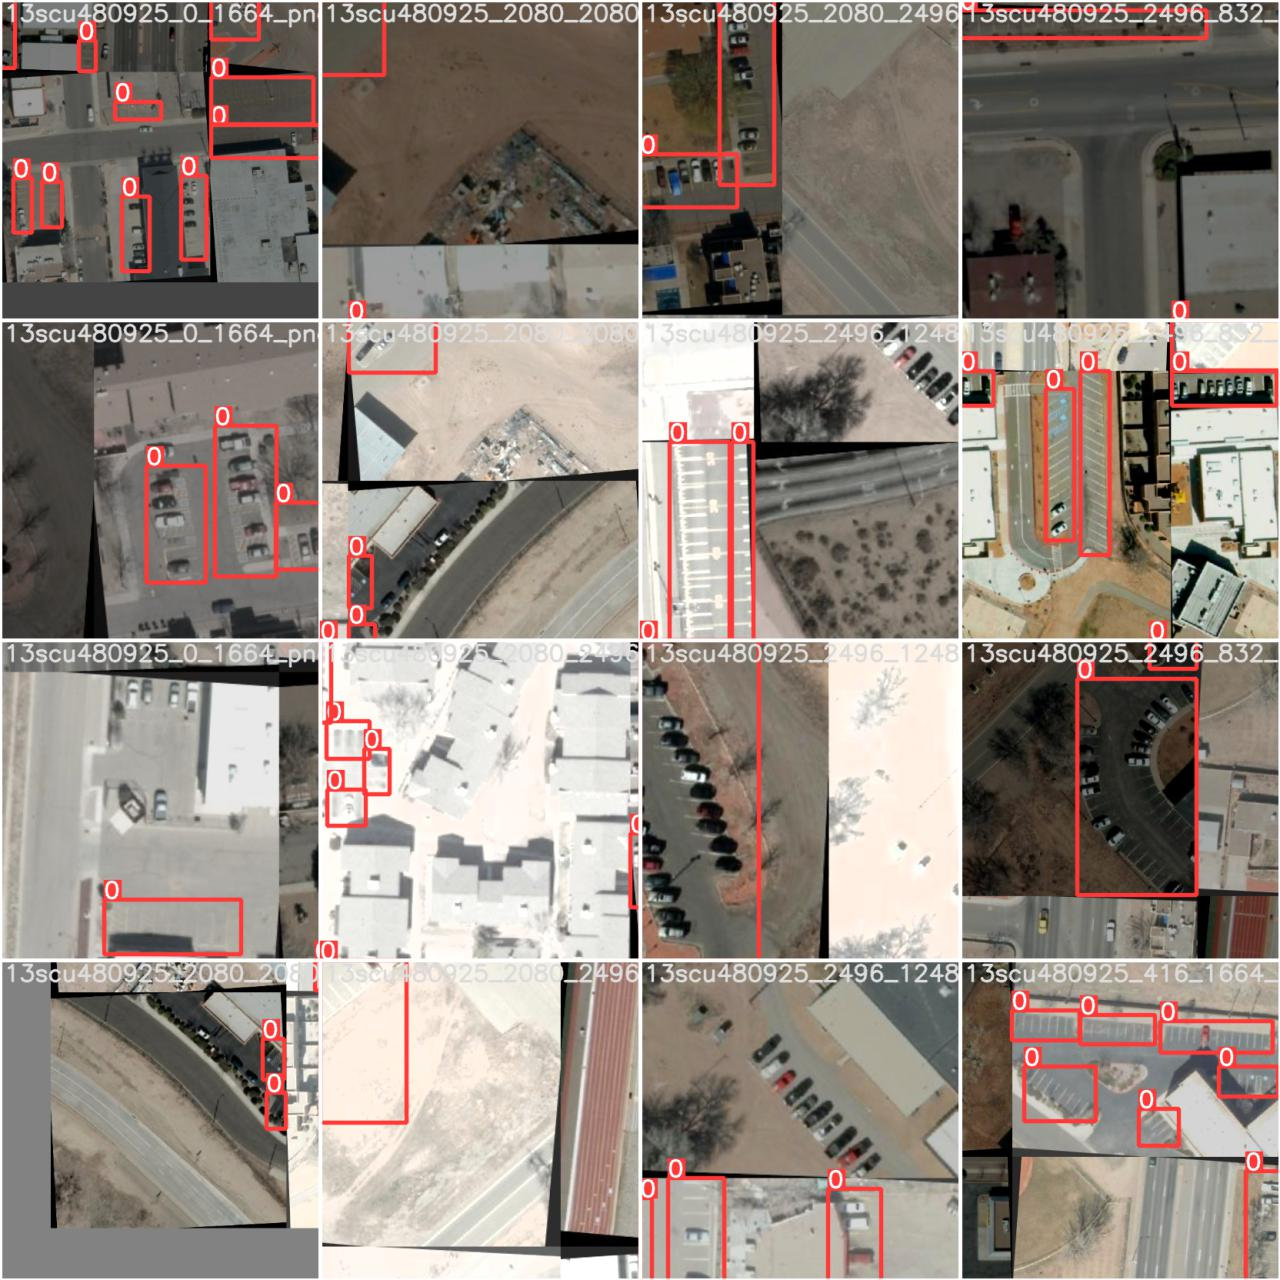

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results2/train_batch0.jpg', width=900)

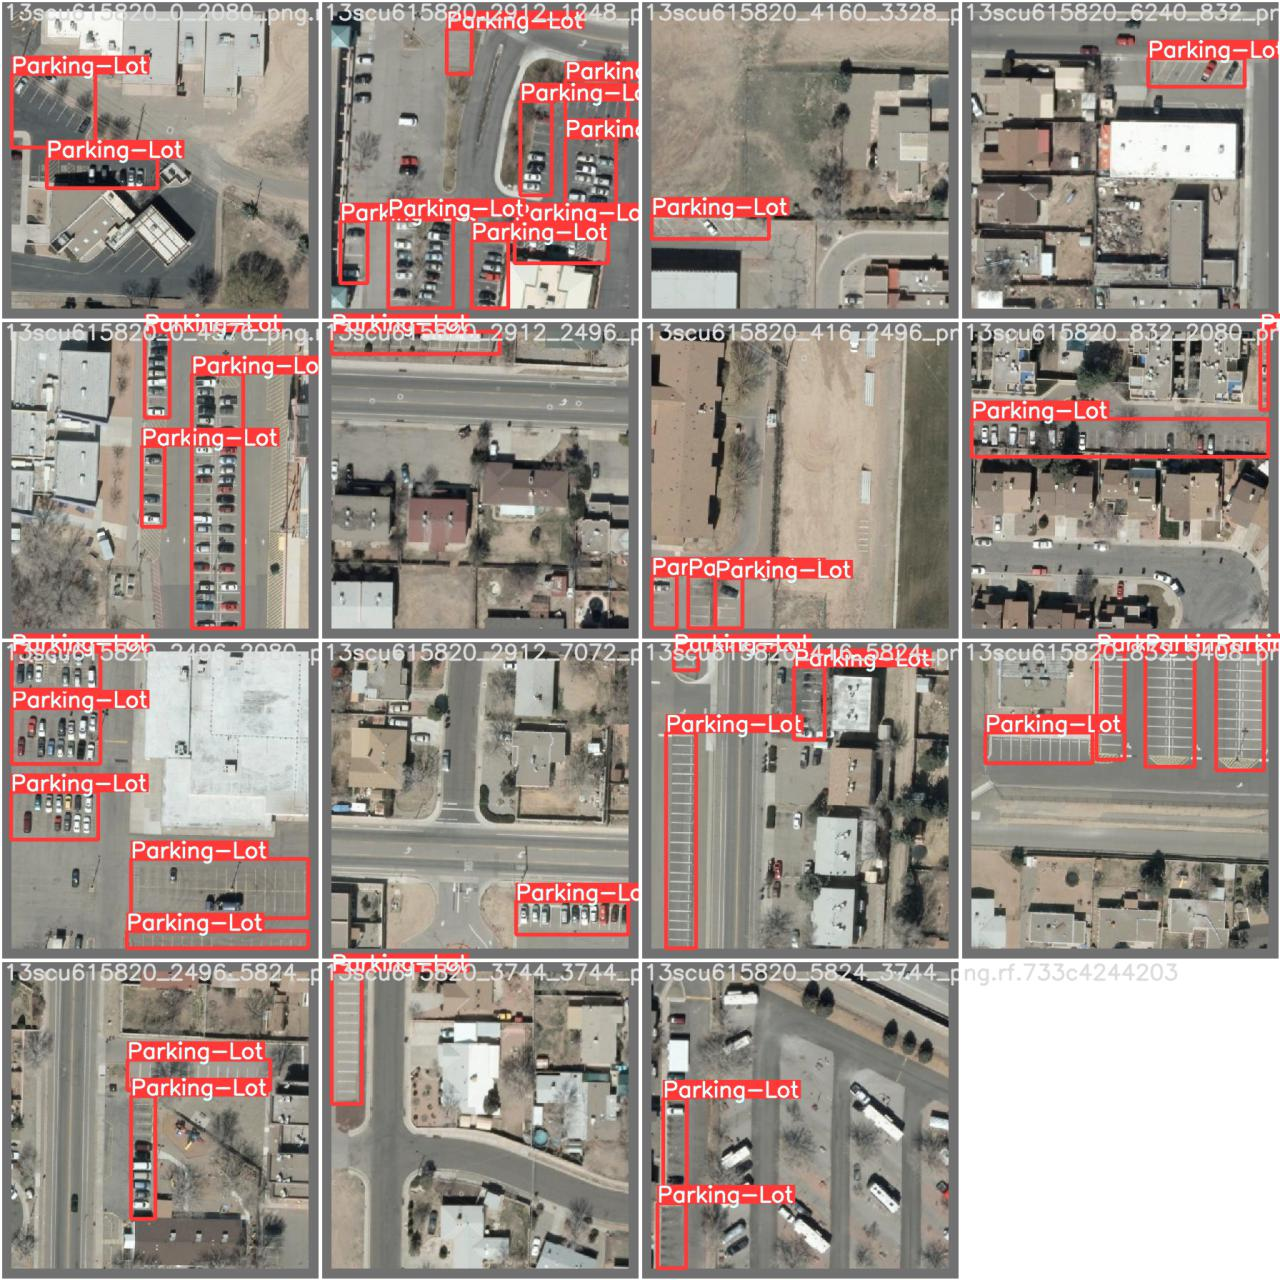

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results2/test_batch0_labels.jpg', width=900)

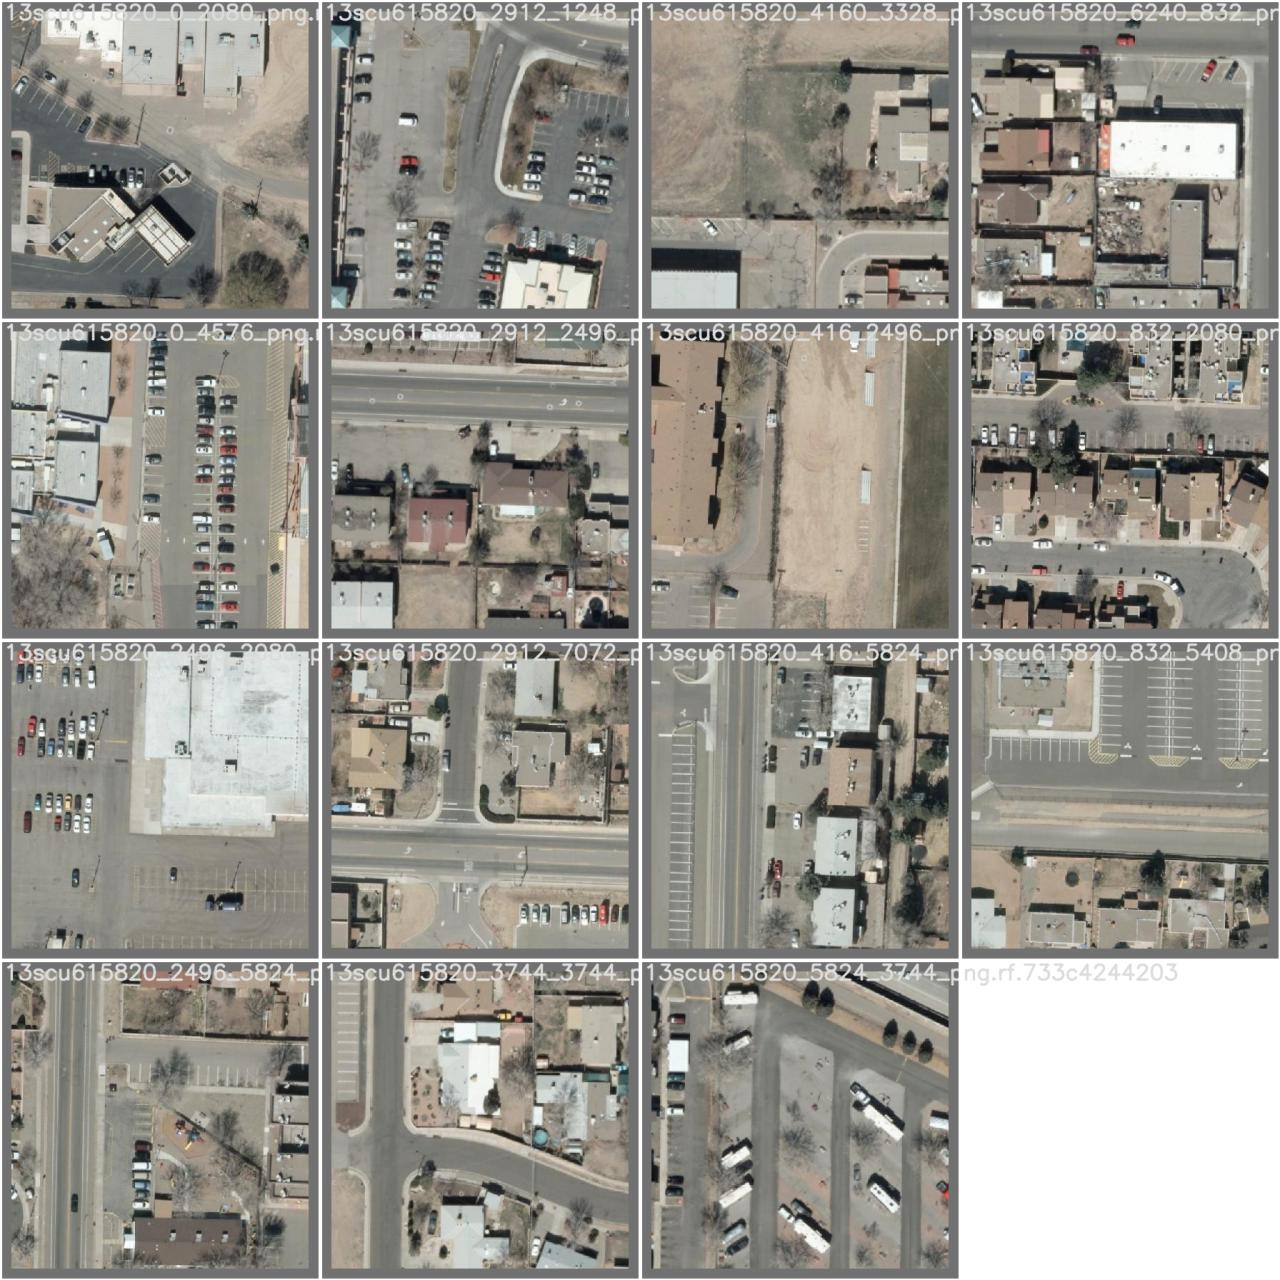

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results2/test_batch0_pred.jpg', width=900)

In [ ]:
from IPython.display import display, Image
import ipywidgets as widgets
import concurrent.futures
import threading

"""
OLD GUI Configuration
"""
class GUI(object):
  _SOURCE_PATH = os.path.join(os.path.abspath(os.getcwd()), "drive", "MyDrive", "Slices")
  _TRN_PATH = os.path.join(os.path.abspath(os.getcwd()), "drive", "MyDrive", "Training Slices")
  _OBS_PATH = os.path.join(os.path.abspath(os.getcwd()), "drive", "MyDrive", "Obsolete Slices")

  def __init__(self, image_relative_paths: list):
    self.paths = image_relative_paths
    self.buffered_images = list()
    self.buffer_index = 0
    self._lock = threading.Lock()
    self.hbox = None

  @staticmethod
  def _move_image(file_path, destination_path):
    file_name = file_path.split("/")[-1]
    destination = os.path.join(destination_path, file_name)
    os.rename(file_path, destination)

  def _handle_button_press(self, widget, callback):
    hbox_children = list(self.hbox.children)
    hbox_children.remove(widget)
    self.hbox.children = hbox_children
    widget.close()

    target_functions = (callback, self._load_next_image, self._display_batch)

    for function in target_functions:
      threading.Thread(target=function).start()

  def _forward_move_image(self, widget, path):
    self._handle_button_press(widget, lambda: GUI._move_image(path, GUI._OBS_PATH)) # Move image to an obsolete directory

  def _forward_skip_image(self, widget, path):
    self._handle_button_press(widget, lambda: GUI._move_image(path, GUI._TRN_PATH)) # Move image to a training directory

  def _config_widgets(self, path, image_bytes):
    button_yes = widgets.Button(description="Yes")
    button_no = widgets.Button(description="No")
    image = widgets.Image(value=image_bytes, format='png')

    inner_hbox = widgets.HBox(layout=widgets.Layout(justify_content="center", display="inline-flex", flex_flow="row wrap"))
    vbox = widgets.VBox()
    inner_hbox.children = [button_yes, button_no]
    vbox.children = [inner_hbox, image]

    button_yes.on_click(lambda widget: self._forward_skip_image(vbox, path))
    button_no.on_click(lambda widget: self._forward_move_image(vbox, path))

    self.hbox.children += (vbox,)

  def _load_next_image(self):
    self._lock.acquire() # Critical section start
    if self.buffer_index < len(self.paths):
      current_file_path = os.path.join(GUI._SOURCE_PATH, self.paths[self.buffer_index])
      self.buffer_index += 1
      self._lock.release() # Critical section end
      self.buffered_images.append((current_file_path, open(current_file_path, "rb").read()))
    else:
      self._lock.release()

  def _display_batch(self):
    if self.buffered_images:
      path, image_bytes = self.buffered_images.pop(0)
      self._config_widgets(path, image_bytes)

  def _display_hbox(self):
    for _ in range(3):
      self._display_batch()

    display(self.hbox)


  def boot_up(self):
    with concurrent.futures.ThreadPoolExecutor() as executor:
      for i in range(4): # Buffer 4 images 
        executor.submit(self._load_next_image)

    self.hbox = widgets.HBox(layout=widgets.Layout(width='100%', display="inline-flex", flex_flow="row wrap"))
    self._display_hbox()